# MERGE BLOCS WITH STATIONS, LOCATE 3 CLOSEST STATIONS

In [1]:
import os
import pandas as pd
import numpy as np
from random import randint, uniform
from datetime import datetime
from urllib import urlretrieve
from zipfile import ZipFile
import fiona 


from shapely.geometry import Point
from shapely.geometry import Polygon

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (10.0, 10.0)


# 1. Station data

In [2]:
#1 - BRING IN STATION DATA - FROM SQL ALL UNIQUE STATIONS
from geopandas import GeoDataFrame
from shapely.geometry import Point
stationinfo = pd.read_csv('stationinfo.csv')

In [3]:
stationinfo.head()

,Unnamed: 0,stationname,stationlat,stationlong,stationid,datetime,year,month,total_months,as_start_count,as_end_count,as_start_avg,as_end_avg
0,0,10 Ave & W 28 St,40.750664,-74.001768,489,2013-07-01 00:20:44,2013,7,41,96274,96591,2348.146341,2355.878049
1,1,10 St & 5 Ave,40.668627,-73.987001,3317,2016-08-26 21:49:37,2016,8,4,1839,1838,459.750000,459.500000
2,2,10 St & 7 Ave,40.666208,-73.981999,3306,2016-08-25 16:18:18,2016,8,4,2870,2705,717.500000,676.250000
3,3,11 Ave & W 27 St,40.751396,-74.005226,458,2013-07-01 00:03:58,2013,7,41,145438,147743,3547.268293,3603.487805
4,4,11 Ave & W 41 St,40.760301,-73.998842,478,2013-07-01 00:21:22,2013,7,41,121505,125955,2963.536585,3072.073171


In [4]:
# OUTLIERS?
stationinfo.stationlat.sort_values().head(10)

520     0.000000
277    40.445350
78     40.517975
128    40.646538
440    40.646678
590    40.646678
523    40.646768
704    40.661063
121    40.662987
9      40.663779
Name: stationlat, dtype: float64

In [5]:
# CORRECT OUTLIER
stationinfo.set_value(277, 'stationlat', 40.748294)

,Unnamed: 0,stationname,stationlat,stationlong,stationid,datetime,year,month,total_months,as_start_count,as_end_count,as_start_avg,as_end_avg
0,0,10 Ave & W 28 St,40.750664,-74.001768,489,2013-07-01 00:20:44,2013,7,41,96274,96591,2348.146341,2355.878049
1,1,10 St & 5 Ave,40.668627,-73.987001,3317,2016-08-26 21:49:37,2016,8,4,1839,1838,459.750000,459.500000
2,2,10 St & 7 Ave,40.666208,-73.981999,3306,2016-08-25 16:18:18,2016,8,4,2870,2705,717.500000,676.250000
3,3,11 Ave & W 27 St,40.751396,-74.005226,458,2013-07-01 00:03:58,2013,7,41,145438,147743,3547.268293,3603.487805
4,4,11 Ave & W 41 St,40.760301,-73.998842,478,2013-07-01 00:21:22,2013,7,41,121505,125955,2963.536585,3072.073171
5,5,11 Ave & W 59 St,40.771522,-73.990541,530,2014-03-01 08:50:11,2014,3,33,89290,93779,2705.757576,2841.787879
6,6,12 Ave & W 40 St,40.760875,-74.002777,514,2013-07-01 03:16:50,2013,7,41,186694,201171,4553.512195,4906.609756
7,7,12 St & 4 Ave,40.668603,-73.990439,3322,2016-08-26 17:12:22,2016,8,4,1465,1506,366.250000,376.500000
8,8,14 St & 5 Ave,40.666287,-73.988951,3319,2016-09-01 08:35:36,2016,9,3,2756,2785,918.666667,928.333333
9,9,14 St & 7 Ave,40.663779,-73.983968,3310,2016-08-25 14:15:30,2016,8,4,2967,2897,741.750000,724.250000


In [6]:
stationinfo.shape

(720, 13)

In [7]:
# REMOVE OUTLIERS (CITIBIKE DEPOTS)
stationinfo = stationinfo.drop([520, 78, 128, 440, 590, 523, 76]).reset_index()

In [8]:
stationinfo.shape

(713, 14)

In [9]:
stationinfo.head()

,index,Unnamed: 0,stationname,stationlat,stationlong,stationid,datetime,year,month,total_months,as_start_count,as_end_count,as_start_avg,as_end_avg
0,0,0,10 Ave & W 28 St,40.750664,-74.001768,489,2013-07-01 00:20:44,2013,7,41,96274,96591,2348.146341,2355.878049
1,1,1,10 St & 5 Ave,40.668627,-73.987001,3317,2016-08-26 21:49:37,2016,8,4,1839,1838,459.750000,459.500000
2,2,2,10 St & 7 Ave,40.666208,-73.981999,3306,2016-08-25 16:18:18,2016,8,4,2870,2705,717.500000,676.250000
3,3,3,11 Ave & W 27 St,40.751396,-74.005226,458,2013-07-01 00:03:58,2013,7,41,145438,147743,3547.268293,3603.487805
4,4,4,11 Ave & W 41 St,40.760301,-73.998842,478,2013-07-01 00:21:22,2013,7,41,121505,125955,2963.536585,3072.073171


In [10]:
# REMOVE DUPLICATES 
stationinfo_final = stationinfo.drop_duplicates(subset=['stationid', 'stationlat', 'stationlong']).reset_index()

In [11]:
stationinfo_final = stationinfo_final.drop(['Unnamed: 0', 'level_0','index'],1)

In [12]:
stationinfo_final.shape

(699, 12)

In [13]:
stationinfo_final.tail()

,stationname,stationlat,stationlong,stationid,datetime,year,month,total_months,as_start_count,as_end_count,as_start_avg,as_end_avg
694,Wolcott St & Dwight St,40.675327,-74.010070,3340,2016-08-23 17:40:52,2016,8,4,794,918,198.500000,229.500000
695,Wyckoff St & 3 Ave,40.682755,-73.982586,3413,2016-08-18 17:21:00,2016,8,4,2013,1972,503.250000,493.000000
696,Wythe Ave & Metropolitan Ave,40.716887,-73.963198,2002,2013-07-01 00:26:30,2013,7,41,71250,75064,1737.804878,1830.829268
697,Yankee Ferry Terminal,40.686931,-74.016966,3182,2015-08-04 14:22:01,2015,8,16,8621,8674,538.812500,542.125000
698,York St & Jay St,40.701485,-73.986569,430,2013-07-01 00:12:16,2013,7,41,71832,74943,1752.000000,1827.878049


In [166]:
stationinfo_final.to_csv("11.Final_station_data.csv")

## 2. Merge NYC blocs with CB stations

In [14]:
# CONVERT STATION DATAFRAME TO GEODATAFRAME
crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(stationinfo_final.stationlong, stationinfo_final.stationlat)]
stat_gdf = GeoDataFrame(stationinfo_final, crs=crs, geometry=geometry)

In [15]:
stat_gdf.head()

,stationname,stationlat,stationlong,stationid,datetime,year,month,total_months,as_start_count,as_end_count,as_start_avg,as_end_avg,geometry
0,10 Ave & W 28 St,40.750664,-74.001768,489,2013-07-01 00:20:44,2013,7,41,96274,96591,2348.146341,2355.878049,POINT (-74.00176802 40.75066386)
1,10 St & 5 Ave,40.668627,-73.987001,3317,2016-08-26 21:49:37,2016,8,4,1839,1838,459.750000,459.500000,POINT (-73.98700053 40.6686273)
2,10 St & 7 Ave,40.666208,-73.981999,3306,2016-08-25 16:18:18,2016,8,4,2870,2705,717.500000,676.250000,POINT (-73.98199886 40.6662078)
3,11 Ave & W 27 St,40.751396,-74.005226,458,2013-07-01 00:03:58,2013,7,41,145438,147743,3547.268293,3603.487805,POINT (-74.00522600000001 40.751396)
4,11 Ave & W 41 St,40.760301,-73.998842,478,2013-07-01 00:21:22,2013,7,41,121505,125955,2963.536585,3072.073171,POINT (-73.99884222 40.76030096)


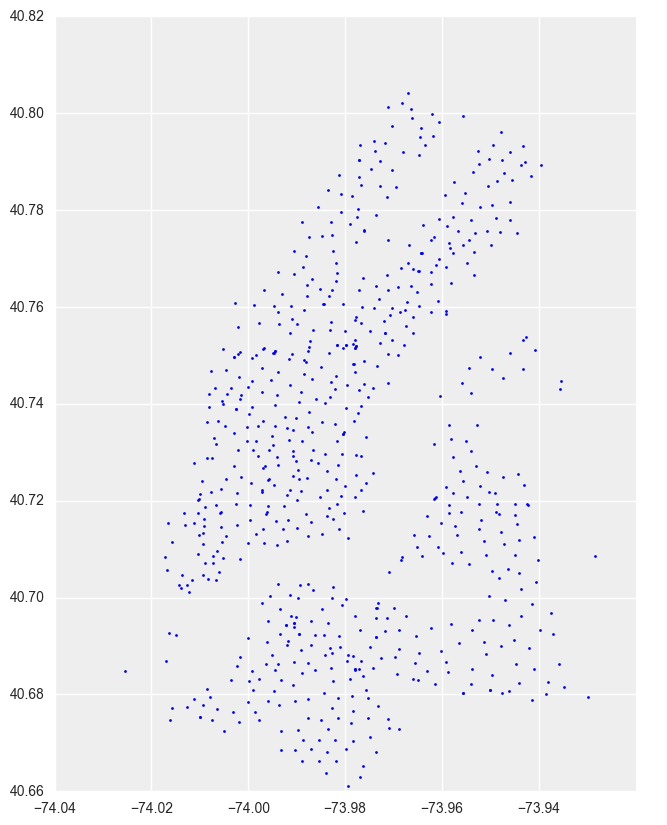

In [16]:
stat_gdf.plot(color='b')

In [17]:
stat_gdf.shape

(699, 13)

In [18]:
stat_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 13 columns):
stationname       699 non-null object
stationlat        699 non-null float64
stationlong       699 non-null float64
stationid         699 non-null int64
datetime          699 non-null object
year              699 non-null int64
month             699 non-null int64
total_months      699 non-null int64
as_start_count    699 non-null int64
as_end_count      699 non-null int64
as_start_avg      699 non-null float64
as_end_avg        699 non-null float64
geometry          699 non-null object
dtypes: float64(4), int64(6), object(3)
memory usage: 71.1+ KB


In [19]:
# BRING IN CENSUS BLOC DATA
import fiona
import geopandas as gpd
from geopandas import GeoDataFrame 
import shapefile
blocshapes = gpd.GeoDataFrame.from_file('mappy.dbf')
blocshapes.head()

,admin_fire,assemdist,atomic_num,atomicid,borough,censusbl_1,censusbl_2,censusbl_3,censusbloc,censustr_1,...,sb_1_page,sb_1_volum,sb_2_page,sb_2_volum,sb_3_page,sb_3_volum,schooldist,shape_area,shape_leng,water_flag
0,E 151,62,None,5024401430,5,None,1020,None,4023,024401,...,533,05,None,None,None,None,31,244110.620576,2424.560416,2
1,E 151,62,None,5024401439,5,None,2004,None,4030,024401,...,533,05,None,None,None,None,31,177042.348067,1722.931212,2
2,E 151,62,None,5024402223,5,B,1005,None,2002,024402,...,530,05,529,05,None,None,31,33790.843893,770.085650,2
3,E 151,62,None,5024401441,5,None,2005,None,4031,024401,...,533,05,None,None,None,None,31,171623.335762,1697.908522,2
4,E 151,62,None,5024401440,5,None,1018,None,4015,024401,...,532,05,None,None,None,None,31,78855.828376,1243.106869,2


In [20]:
blocshapes.shape

(65788, 26)

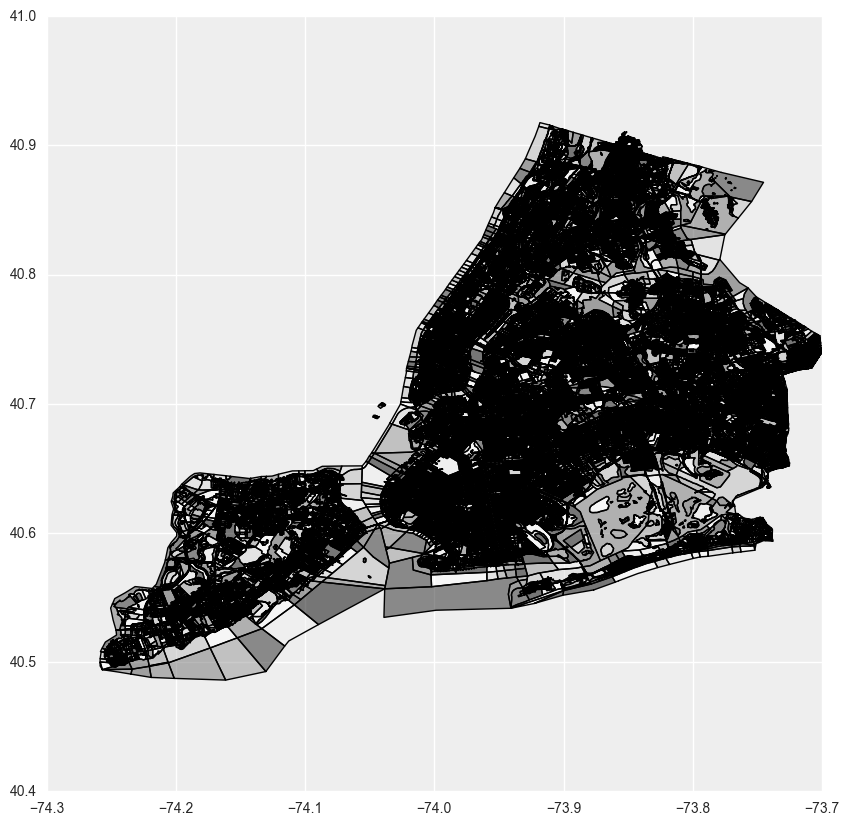

In [259]:
# PLOT CENSUS BLOCS
blocshapes.plot()

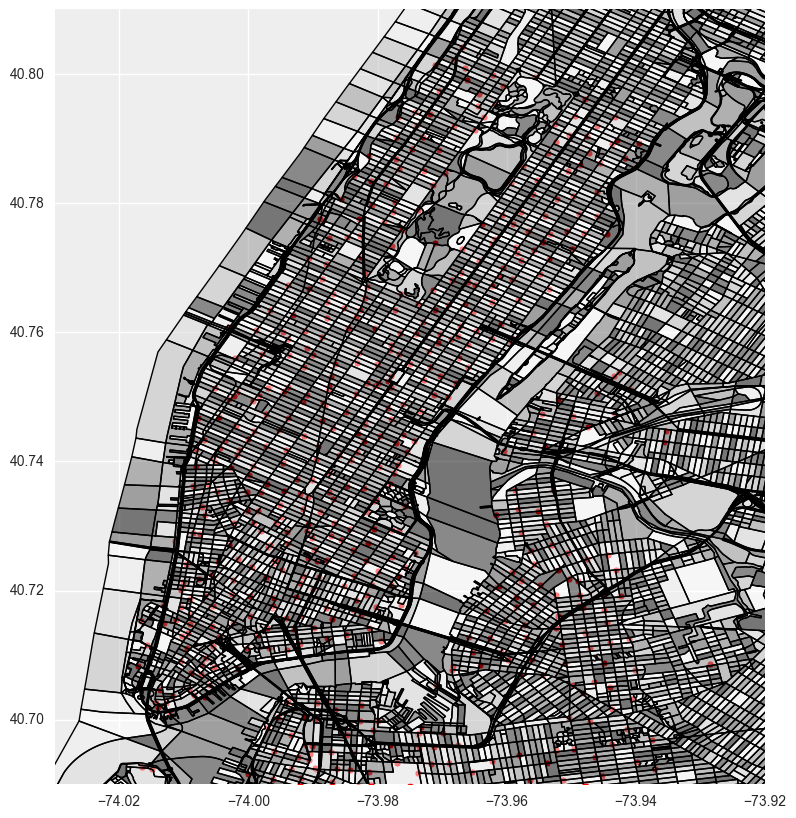

In [261]:
# PLOT CENSUS BLOCS AND STATIONS TOGETHER (ZOOM IN)
blocshapes.plot()
plt.scatter(x=stat_gdf['startstationlongitude'], y=stat_gdf['startstationlatitude'], c='r', s=25)
plt.xlim(-74.03, -73.92)
plt.ylim(40.69, 40.81)
plt.rcParams['figure.figsize'] = (12.0, 12.0)

In [21]:
# JOIN BLOCS AND STATIONS DATA (INNER JOIN)
blocs_stations_inner = gpd.sjoin(blocshapes, stat_gdf, how="inner", op='intersects') #used to be left
blocs_stations_inner.head() 

,admin_fire,assemdist,atomic_num,atomicid,borough,censusbl_1,censusbl_2,censusbl_3,censusbloc,censustr_1,...,stationlong,stationid,datetime,year,month,total_months,as_start_count,as_end_count,as_start_avg,as_end_avg
7886,E 210,57,None,3020100101,3,None,1000,None,1000,020100,...,-73.963040,3049,2015-08-28 13:17:48,2015,8,16,5135,4886,320.937500,305.375000
7895,E 226,52,None,3004100302,3,None,2001,None,3001,004100,...,-73.987591,3410,2016-08-30 10:59:48,2016,8,4,2178,2212,544.500000,553.000000
8000,L 110,52,None,3001100113,3,None,1008,None,1008,001100,...,-73.986317,323,2013-07-01 00:47:37,2013,7,41,75737,77903,1847.243902,1900.073171
8011,E 210,57,None,3003100103,3,None,3000,None,1000,003100,...,-73.977039,245,2013-07-01 09:14:16,2013,7,41,14911,12770,363.682927,311.463415
8011,E 210,57,None,3003100103,3,None,3000,None,1000,003100,...,-73.974931,241,2013-07-01 06:10:15,2013,7,41,28967,26888,706.512195,655.804878


In [22]:
blocs_stations_inner.shape

(699, 39)

(40.65, 40.81)

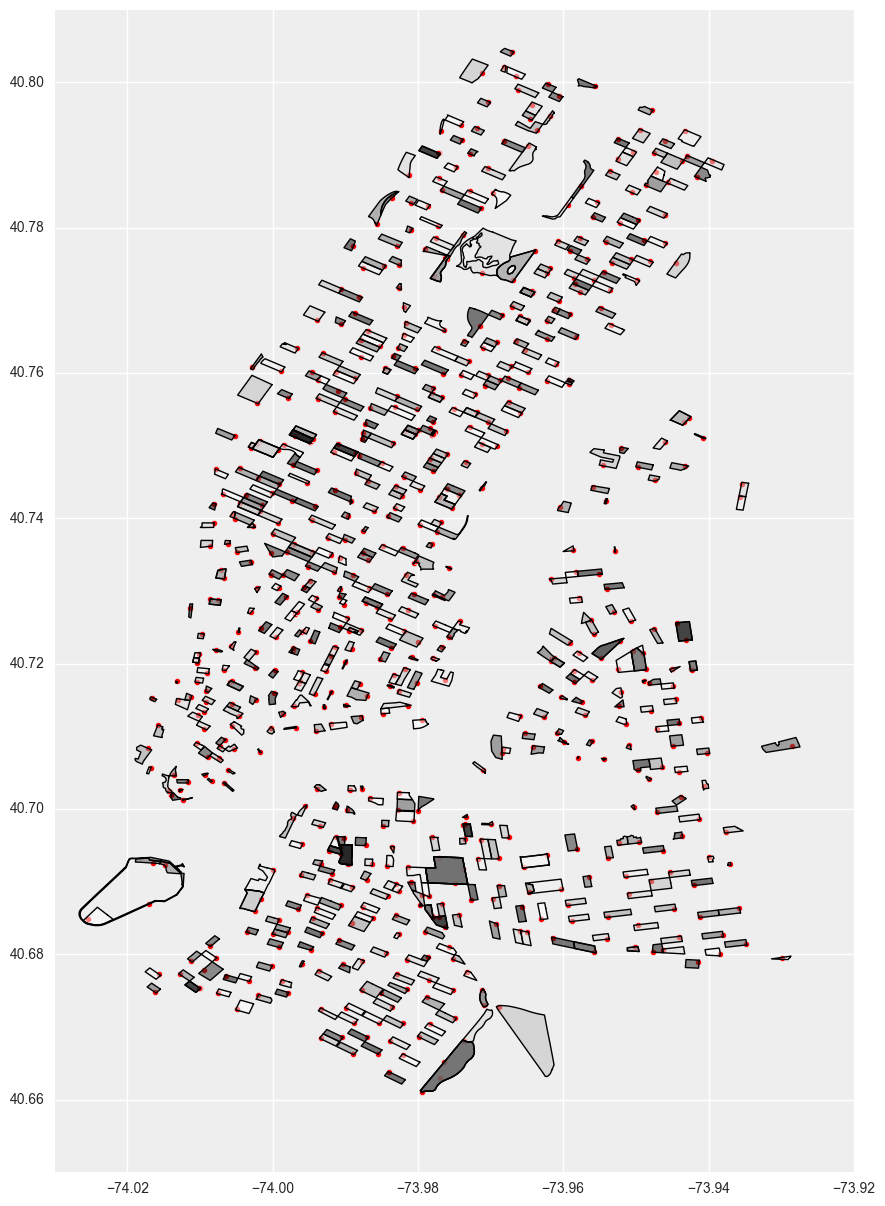

In [27]:
blocs_stations_inner.plot()
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.scatter(x=stat_gdf['stationlong'], y=stat_gdf['stationlat'], c='r', s=20)
plt.xlim(-74.03, -73.92)
plt.ylim(40.65, 40.81)

In [23]:
# GET RELEVANT DATA FROM INNER JOIN
y = pd.DataFrame(blocs_stations_inner[['atomicid','year']])
y.head()

,atomicid,year
7886,3020100101,2015
7895,3004100302,2016
8000,3001100113,2013
8011,3003100103,2013
8011,3003100103,2013


In [24]:
y.shape

(699, 2)

In [51]:
y.head(10)

,atomicid,year
7886,3020100101,2015
7895,3004100302,2016
8000,3001100113,2013
8011,3003100103,2013
8011,3003100103,2013
8011,3003100103,2013
8011,3003100103,2013
8014,3025901103,2015
8134,3024900401,2016
8136,3012902202,2016


In [226]:
y.to_csv("My Y.csv")

## 3. Closests stations to bloc

In [25]:
# FUNCTION TO GET DISTANCE TO AND INDEX OF THE CLOSESTS STATIONS TO BLOC
def closest_stations(x):
    distances=[]
    for i,j in enumerate(stat_gdf.geometry):    
        distance = x.distance(j)
        distances.append((distance, i)) 
    distances = sorted(distances)        
    return distances[0:8]

In [26]:
blocshapes['closest_stations_data'] = blocshapes.geometry.apply(closest_stations) 

In [27]:
blocshapes.head()

,admin_fire,assemdist,atomic_num,atomicid,borough,censusbl_1,censusbl_2,censusbl_3,censusbloc,censustr_1,...,sb_1_volum,sb_2_page,sb_2_volum,sb_3_page,sb_3_volum,schooldist,shape_area,shape_leng,water_flag,closest_stations_data
0,E 151,62,None,5024401430,5,None,1020,None,4023,024401,...,05,None,None,None,None,31,244110.620576,2424.560416,2,"[(0.283613487227, 75), (0.284857869791, 541), ..."
1,E 151,62,None,5024401439,5,None,2004,None,4030,024401,...,05,None,None,None,None,31,177042.348067,1722.931212,2,"[(0.278753384032, 75), (0.279811048048, 541), ..."
2,E 151,62,None,5024402223,5,B,1005,None,2002,024402,...,05,529,05,None,None,31,33790.843893,770.085650,2,"[(0.272003943985, 75), (0.27280117115, 541), (..."
3,E 151,62,None,5024401441,5,None,2005,None,4031,024401,...,05,None,None,None,None,31,171623.335762,1697.908522,2,"[(0.277706588974, 75), (0.27873651588, 541), (..."
4,E 151,62,None,5024401440,5,None,1018,None,4015,024401,...,05,None,None,None,None,31,78855.828376,1243.106869,2,"[(0.287893095872, 75), (0.289309190934, 541), ..."


In [28]:
# CHECK IF STATIONS ARE INSIDE THE BLOC
def test_inside(x):
    if x[3][0] == 0.0:
        return x[4:]
    elif x[2][0] == 0.0:
        return x[3:]
    elif x[1][0] == 0.0:
        return x[2:]
    if x[0][0] == 0.0:
        return x[1:]
    else:
        return x

In [29]:
blocshapes['checked_closest_stations_data'] = blocshapes.closest_stations_data.apply(test_inside) 

In [30]:
blocshapes.head()

,admin_fire,assemdist,atomic_num,atomicid,borough,censusbl_1,censusbl_2,censusbl_3,censusbloc,censustr_1,...,sb_2_page,sb_2_volum,sb_3_page,sb_3_volum,schooldist,shape_area,shape_leng,water_flag,closest_stations_data,checked_closest_stations_data
0,E 151,62,None,5024401430,5,None,1020,None,4023,024401,...,None,None,None,None,31,244110.620576,2424.560416,2,"[(0.283613487227, 75), (0.284857869791, 541), ...","[(0.283613487227, 75), (0.284857869791, 541), ..."
1,E 151,62,None,5024401439,5,None,2004,None,4030,024401,...,None,None,None,None,31,177042.348067,1722.931212,2,"[(0.278753384032, 75), (0.279811048048, 541), ...","[(0.278753384032, 75), (0.279811048048, 541), ..."
2,E 151,62,None,5024402223,5,B,1005,None,2002,024402,...,529,05,None,None,31,33790.843893,770.085650,2,"[(0.272003943985, 75), (0.27280117115, 541), (...","[(0.272003943985, 75), (0.27280117115, 541), (..."
3,E 151,62,None,5024401441,5,None,2005,None,4031,024401,...,None,None,None,None,31,171623.335762,1697.908522,2,"[(0.277706588974, 75), (0.27873651588, 541), (...","[(0.277706588974, 75), (0.27873651588, 541), (..."
4,E 151,62,None,5024401440,5,None,1018,None,4015,024401,...,None,None,None,None,31,78855.828376,1243.106869,2,"[(0.287893095872, 75), (0.289309190934, 541), ...","[(0.287893095872, 75), (0.289309190934, 541), ..."


In [31]:
# SANITY CHECK
blocshapes.iloc[8011]

admin_fire                                                                   E 210
assemdist                                                                       57
atomic_num                                                                    None
atomicid                                                                3003100103
borough                                                                          3
censusbl_1                                                                    None
censusbl_2                                                                    3000
censusbl_3                                                                    None
censusbloc                                                                    1000
censustr_1                                                                  003100
censustr_2                                                                  003100
censustrac                                                                  003100
comm

In [32]:
# ORGANIZE / SEPERATE STATIONS
blocshapes['station1_data'] = blocshapes.checked_closest_stations_data.apply(lambda x: x[0])
blocshapes['station2_data'] = blocshapes.checked_closest_stations_data.apply(lambda x: x[1])
blocshapes['station3_data'] = blocshapes.checked_closest_stations_data.apply(lambda x: x[2])

In [33]:
blocshapes.head()

,admin_fire,assemdist,atomic_num,atomicid,borough,censusbl_1,censusbl_2,censusbl_3,censusbloc,censustr_1,...,sb_3_volum,schooldist,shape_area,shape_leng,water_flag,closest_stations_data,checked_closest_stations_data,station1_data,station2_data,station3_data
0,E 151,62,None,5024401430,5,None,1020,None,4023,024401,...,None,31,244110.620576,2424.560416,2,"[(0.283613487227, 75), (0.284857869791, 541), ...","[(0.283613487227, 75), (0.284857869791, 541), ...","(0.283613487227, 75)","(0.284857869791, 541)","(0.286684043786, 194)"
1,E 151,62,None,5024401439,5,None,2004,None,4030,024401,...,None,31,177042.348067,1722.931212,2,"[(0.278753384032, 75), (0.279811048048, 541), ...","[(0.278753384032, 75), (0.279811048048, 541), ...","(0.278753384032, 75)","(0.279811048048, 541)","(0.28165949865, 194)"
2,E 151,62,None,5024402223,5,B,1005,None,2002,024402,...,None,31,33790.843893,770.085650,2,"[(0.272003943985, 75), (0.27280117115, 541), (...","[(0.272003943985, 75), (0.27280117115, 541), (...","(0.272003943985, 75)","(0.27280117115, 541)","(0.274680086933, 194)"
3,E 151,62,None,5024401441,5,None,2005,None,4031,024401,...,None,31,171623.335762,1697.908522,2,"[(0.277706588974, 75), (0.27873651588, 541), (...","[(0.277706588974, 75), (0.27873651588, 541), (...","(0.277706588974, 75)","(0.27873651588, 541)","(0.2805882025, 194)"
4,E 151,62,None,5024401440,5,None,1018,None,4015,024401,...,None,31,78855.828376,1243.106869,2,"[(0.287893095872, 75), (0.289309190934, 541), ...","[(0.287893095872, 75), (0.289309190934, 541), ...","(0.287893095872, 75)","(0.289309190934, 541)","(0.291114531374, 194)"


In [34]:
# SEPERATE INFO
blocshapes['station1_distance'] = blocshapes.station1_data.apply(lambda x: x[0])
blocshapes['station1_index'] = blocshapes.station1_data.apply(lambda x: x[1])

blocshapes['station2_distance'] = blocshapes.station2_data.apply(lambda x: x[0])
blocshapes['station2_index'] = blocshapes.station2_data.apply(lambda x: x[1])

blocshapes['station3_distance'] = blocshapes.station3_data.apply(lambda x: x[0])
blocshapes['station3_index'] = blocshapes.station3_data.apply(lambda x: x[1])

In [35]:
blocshapes.head()

,admin_fire,assemdist,atomic_num,atomicid,borough,censusbl_1,censusbl_2,censusbl_3,censusbloc,censustr_1,...,checked_closest_stations_data,station1_data,station2_data,station3_data,station1_distance,station1_index,station2_distance,station2_index,station3_distance,station3_index
0,E 151,62,None,5024401430,5,None,1020,None,4023,024401,...,"[(0.283613487227, 75), (0.284857869791, 541), ...","(0.283613487227, 75)","(0.284857869791, 541)","(0.286684043786, 194)",0.283613,75,0.284858,541,0.286684,194
1,E 151,62,None,5024401439,5,None,2004,None,4030,024401,...,"[(0.278753384032, 75), (0.279811048048, 541), ...","(0.278753384032, 75)","(0.279811048048, 541)","(0.28165949865, 194)",0.278753,75,0.279811,541,0.281659,194
2,E 151,62,None,5024402223,5,B,1005,None,2002,024402,...,"[(0.272003943985, 75), (0.27280117115, 541), (...","(0.272003943985, 75)","(0.27280117115, 541)","(0.274680086933, 194)",0.272004,75,0.272801,541,0.274680,194
3,E 151,62,None,5024401441,5,None,2005,None,4031,024401,...,"[(0.277706588974, 75), (0.27873651588, 541), (...","(0.277706588974, 75)","(0.27873651588, 541)","(0.2805882025, 194)",0.277707,75,0.278737,541,0.280588,194
4,E 151,62,None,5024401440,5,None,1018,None,4015,024401,...,"[(0.287893095872, 75), (0.289309190934, 541), ...","(0.287893095872, 75)","(0.289309190934, 541)","(0.291114531374, 194)",0.287893,75,0.289309,541,0.291115,194


In [36]:
blocshapes.columns

Index([                   u'admin_fire',                     u'assemdist',
                          u'atomic_num',                      u'atomicid',
                             u'borough',                    u'censusbl_1',
                          u'censusbl_2',                    u'censusbl_3',
                          u'censusbloc',                    u'censustr_1',
                          u'censustr_2',                    u'censustrac',
                            u'commdist',                     u'electdist',
                            u'geometry',                     u'hurricane',
                           u'sb_1_page',                    u'sb_1_volum',
                           u'sb_2_page',                    u'sb_2_volum',
                           u'sb_3_page',                    u'sb_3_volum',
                          u'schooldist',                    u'shape_area',
                          u'shape_leng',                    u'water_flag',
               u'closest_

In [198]:
blocshapes.to_csv("Blocs and nearest stations.csv")

In [37]:
# MERGE WHEN BLOC HAS A STATION
mergestations = gpd.sjoin(blocshapes, stat_gdf, how="left", op='intersects') 
mergestations.head() 

,admin_fire,assemdist,atomic_num,atomicid,borough,censusbl_1,censusbl_2,censusbl_3,censusbloc,censustr_1,...,stationlong,stationid,datetime,year,month,total_months,as_start_count,as_end_count,as_start_avg,as_end_avg
0,E 151,62,None,5024401430,5,None,1020,None,4023,024401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E 151,62,None,5024401439,5,None,2004,None,4030,024401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E 151,62,None,5024402223,5,B,1005,None,2002,024402,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E 151,62,None,5024401441,5,None,2005,None,4031,024401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E 151,62,None,5024401440,5,None,1018,None,4015,024401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
mergestations.shape

(65849, 50)

In [39]:
mergestations.columns

Index([                   u'admin_fire',                     u'assemdist',
                          u'atomic_num',                      u'atomicid',
                             u'borough',                    u'censusbl_1',
                          u'censusbl_2',                    u'censusbl_3',
                          u'censusbloc',                    u'censustr_1',
                          u'censustr_2',                    u'censustrac',
                            u'commdist',                     u'electdist',
                            u'geometry',                     u'hurricane',
                           u'sb_1_page',                    u'sb_1_volum',
                           u'sb_2_page',                    u'sb_2_volum',
                           u'sb_3_page',                    u'sb_3_volum',
                          u'schooldist',                    u'shape_area',
                          u'shape_leng',                    u'water_flag',
               u'closest_

In [40]:
mergestations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 65849 entries, 0 to 65787
Data columns (total 50 columns):
admin_fire                       65849 non-null object
assemdist                        65849 non-null object
atomic_num                       1 non-null object
atomicid                         65849 non-null object
borough                          65849 non-null object
censusbl_1                       5388 non-null object
censusbl_2                       65849 non-null object
censusbl_3                       0 non-null object
censusbloc                       65849 non-null object
censustr_1                       65849 non-null object
censustr_2                       65849 non-null object
censustrac                       65849 non-null object
commdist                         65849 non-null object
electdist                        65849 non-null object
geometry                         65849 non-null object
hurricane                        65849 non-null object
sb_1_page   

In [41]:
# REMOVE UNNECESSARY COLUMNS
blocs_station_closest3 = mergestations.drop(['admin_fire','atomic_num', 'censusbl_1', 'censusbl_2', 'censusbl_3', 
              'censustr_1', 'censustr_2', 'hurricane', 'sb_1_page', 'sb_1_volum', 'sb_2_page','sb_2_volum',
              'sb_3_page', 'sb_3_volum','closest_stations_data','checked_closest_stations_data','station1_data',
            'station2_data','station3_data', 'geometry', 'stationname','stationlat', 'stationlong', 'datetime', 
                                              'month', 'index_right' ],1)

In [42]:
blocs_station_closest3.head()

,assemdist,atomicid,borough,censusbloc,censustrac,commdist,electdist,schooldist,shape_area,shape_leng,...,station2_index,station3_distance,station3_index,stationid,year,total_months,as_start_count,as_end_count,as_start_avg,as_end_avg
0,62,5024401430,5,4023,024400,503,002,31,244110.620576,2424.560416,...,541,0.286684,194,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,62,5024401439,5,4030,024400,503,004,31,177042.348067,1722.931212,...,541,0.281659,194,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,62,5024402223,5,2002,024400,503,005,31,33790.843893,770.085650,...,541,0.274680,194,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,62,5024401441,5,4031,024400,503,004,31,171623.335762,1697.908522,...,541,0.280588,194,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,62,5024401440,5,4015,024400,503,002,31,78855.828376,1243.106869,...,541,0.291115,194,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
blocs_station_closest3.count()

assemdist            65849
atomicid             65849
borough              65849
censusbloc           65849
censustrac           65849
commdist             65849
electdist            65849
schooldist           65849
shape_area           65849
shape_leng           65849
water_flag           65849
station1_distance    65849
station1_index       65849
station2_distance    65849
station2_index       65849
station3_distance    65849
station3_index       65849
stationid              699
year                   699
total_months           699
as_start_count         699
as_end_count           699
as_start_avg           699
as_end_avg             699
dtype: int64

In [44]:
blocs_station_closest3.shape

(65849, 24)

In [45]:
blocs_station_closest3.tail()

,assemdist,atomicid,borough,censusbloc,censustrac,commdist,electdist,schooldist,shape_area,shape_leng,...,station2_index,station3_distance,station3_index,stationid,year,total_months,as_start_count,as_end_count,as_start_avg,as_end_avg
65783,52,3015900102,3,1004,015900,355,072,13,7.684149e+04,1050.376069,...,379,0.002313,116,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65784,64,5015400113,5,1001,015400,595,009,31,1.201969e+07,18674.092876,...,75,0.164379,194,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65785,68,1014300155,1,1008,014300,164,099,3,4.382926e+04,1047.343293,...,165,0.003612,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65786,68,1014300248,1,1009,014300,164,099,3,1.455554e+05,1775.844832,...,600,0.002928,168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65787,63,5022800938,5,3041,029102,502,018,31,2.448943e+06,8256.873672,...,541,0.200158,194,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
blocs_station_closest3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 65849 entries, 0 to 65787
Data columns (total 24 columns):
assemdist            65849 non-null object
atomicid             65849 non-null object
borough              65849 non-null object
censusbloc           65849 non-null object
censustrac           65849 non-null object
commdist             65849 non-null object
electdist            65849 non-null object
schooldist           65849 non-null object
shape_area           65849 non-null float64
shape_leng           65849 non-null float64
water_flag           65849 non-null object
station1_distance    65849 non-null float64
station1_index       65849 non-null int64
station2_distance    65849 non-null float64
station2_index       65849 non-null int64
station3_distance    65849 non-null float64
station3_index       65849 non-null int64
stationid            699 non-null float64
year                 699 non-null float64
total_months         699 non-null float64
as_start_count       699

In [49]:
blocs_station_closest3.to_csv('12.Blocs_station_3stations.csv')

## 4. Prep station info for merges

In [203]:
# CREATE NEW DATAFRAME
closest_station_1 = stationinfo_final
closest_station_1.head()

,stationname,stationlat,stationlong,stationid,datetime,year,month,total_months,as_start_count,as_end_count,as_start_avg,as_end_avg,geometry
0,10 Ave & W 28 St,40.750664,-74.001768,489,2013-07-01 00:20:44,2013,7,41,96274,96591,2348.146341,2355.878049,POINT (-74.00176802 40.75066386)
1,10 St & 5 Ave,40.668627,-73.987001,3317,2016-08-26 21:49:37,2016,8,4,1839,1838,459.750000,459.500000,POINT (-73.98700053 40.6686273)
2,10 St & 7 Ave,40.666208,-73.981999,3306,2016-08-25 16:18:18,2016,8,4,2870,2705,717.500000,676.250000,POINT (-73.98199886 40.6662078)
3,11 Ave & W 27 St,40.751396,-74.005226,458,2013-07-01 00:03:58,2013,7,41,145438,147743,3547.268293,3603.487805,POINT (-74.00522600000001 40.751396)
4,11 Ave & W 41 St,40.760301,-73.998842,478,2013-07-01 00:21:22,2013,7,41,121505,125955,2963.536585,3072.073171,POINT (-73.99884222 40.76030096)


In [204]:
closest_station_1.shape

(699, 13)

In [205]:
closest_station_1 = closest_station_1.drop(['stationname','stationlat', 'stationlong', 'datetime', 'month', 
              'geometry'],1)

In [206]:
closest_station_1.head()

,stationid,year,total_months,as_start_count,as_end_count,as_start_avg,as_end_avg
0,489,2013,41,96274,96591,2348.146341,2355.878049
1,3317,2016,4,1839,1838,459.750000,459.500000
2,3306,2016,4,2870,2705,717.500000,676.250000
3,458,2013,41,145438,147743,3547.268293,3603.487805
4,478,2013,41,121505,125955,2963.536585,3072.073171


In [211]:
# TRANSFORM IT TO FIRST CLOSEST STATION INFO
closest_station_1 = closest_station_1.rename(columns = {'stationid':'stationid1'})
closest_station_1 = closest_station_1.rename(columns = {'year':'year1'})
closest_station_1 = closest_station_1.rename(columns = {'total_months':'total_months1'})
closest_station_1 = closest_station_1.rename(columns = {'as_start_count':'as_start_count1'})
closest_station_1 = closest_station_1.rename(columns = {'as_end_count':'as_end_count1'})
closest_station_1 = closest_station_1.rename(columns = {'as_start_avg':'as_start_avg1'})
closest_station_1 = closest_station_1.rename(columns = {'as_end_avg':'as_end_avg1'})

In [255]:
closest_station_1.head()

,stationid1,year1,total_months1,as_start_count1,as_end_count1,as_start_avg1,as_end_avg1
0,489,2013,41,96274,96591,2348.146341,2355.878049
1,3317,2016,4,1839,1838,459.750000,459.500000
2,3306,2016,4,2870,2705,717.500000,676.250000
3,458,2013,41,145438,147743,3547.268293,3603.487805
4,478,2013,41,121505,125955,2963.536585,3072.073171


In [256]:
closest_station_1.to_csv('First_closest_station.csv')

In [213]:
# CREATE DATAFRAME FOR SECOND CLOSEST STATION
closest_station_2 = closest_station_1

In [214]:
closest_station_2 = closest_station_2.rename(columns = {'stationid1':'stationid2'})
closest_station_2 = closest_station_2.rename(columns = {'year1':'year2'})
closest_station_2 = closest_station_2.rename(columns = {'total_months1':'total_months2'})
closest_station_2 = closest_station_2.rename(columns = {'as_start_count1':'as_start_count2'})
closest_station_2 = closest_station_2.rename(columns = {'as_end_count1':'as_end_count2'})
closest_station_2 = closest_station_2.rename(columns = {'as_start_avg1':'as_start_avg2'})
closest_station_2 = closest_station_2.rename(columns = {'as_end_avg1':'as_end_avg2'})

In [215]:
closest_station_2.head()

,stationid2,year2,total_months2,as_start_count2,as_end_count2,as_start_avg2,as_end_avg2
0,489,2013,41,96274,96591,2348.146341,2355.878049
1,3317,2016,4,1839,1838,459.750000,459.500000
2,3306,2016,4,2870,2705,717.500000,676.250000
3,458,2013,41,145438,147743,3547.268293,3603.487805
4,478,2013,41,121505,125955,2963.536585,3072.073171


In [260]:
closest_station_2.to_csv('Second_closest_station.csv')

In [216]:
# CREATE DATAFRAME FOR SECOND CLOSEST STATION
closest_station_3 = closest_station_1

In [217]:
closest_station_3 = closest_station_3.rename(columns = {'stationid1':'stationid3'})
closest_station_3 = closest_station_3.rename(columns = {'year1':'year3'})
closest_station_3 = closest_station_3.rename(columns = {'total_months1':'total_months3'})
closest_station_3 = closest_station_3.rename(columns = {'as_start_count1':'as_start_count3'})
closest_station_3 = closest_station_3.rename(columns = {'as_end_count1':'as_end_count3'})
closest_station_3 = closest_station_3.rename(columns = {'as_start_avg1':'as_start_avg3'})
closest_station_3 = closest_station_3.rename(columns = {'as_end_avg1':'as_end_avg3'})

In [258]:
closest_station_3.head()

,stationid3,year3,total_months3,as_start_count3,as_end_count3,as_start_avg3,as_end_avg3
0,489,2013,41,96274,96591,2348.146341,2355.878049
1,3317,2016,4,1839,1838,459.750000,459.500000
2,3306,2016,4,2870,2705,717.500000,676.250000
3,458,2013,41,145438,147743,3547.268293,3603.487805
4,478,2013,41,121505,125955,2963.536585,3072.073171


In [257]:
closest_station_3.to_csv("Third_closest_station.csv")

In [259]:
closest_station_3.tail()

,stationid3,year3,total_months3,as_start_count3,as_end_count3,as_start_avg3,as_end_avg3
694,3340,2016,4,794,918,198.500000,229.500000
695,3413,2016,4,2013,1972,503.250000,493.000000
696,2002,2013,41,71250,75064,1737.804878,1830.829268
697,3182,2015,16,8621,8674,538.812500,542.125000
698,430,2013,41,71832,74943,1752.000000,1827.878049


In [270]:
closest_station_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 7 columns):
stationid3         699 non-null int64
year3              699 non-null int64
total_months3      699 non-null int64
as_start_count3    699 non-null int64
as_end_count3      699 non-null int64
as_start_avg3      699 non-null float64
as_end_avg3        699 non-null float64
dtypes: float64(2), int64(5)
memory usage: 38.3 KB


In [228]:
# CREATE DATAFRAME FOR STATION INSIDE BLOCK
inside_station = closest_station_1
inside_station.head()

,stationid1,year1,total_months1,as_start_count1,as_end_count1,as_start_avg1,as_end_avg1
0,489,2013,41,96274,96591,2348.146341,2355.878049
1,3317,2016,4,1839,1838,459.750000,459.500000
2,3306,2016,4,2870,2705,717.500000,676.250000
3,458,2013,41,145438,147743,3547.268293,3603.487805
4,478,2013,41,121505,125955,2963.536585,3072.073171


In [229]:
inside_station = inside_station.rename(columns = {'stationid1':'stationid'})
inside_station = inside_station.rename(columns = {'year1':'year'})
inside_station = inside_station.rename(columns = {'total_months1':'total_months'})
inside_station = inside_station.rename(columns = {'as_start_count1':'as_start_count'})
inside_station = inside_station.rename(columns = {'as_end_count1':'as_end_count'})
inside_station = inside_station.rename(columns = {'as_start_avg1':'as_start_avg'})
inside_station = inside_station.rename(columns = {'as_end_avg1':'as_end_avg'})

In [230]:
inside_station.head()

,stationid,year,total_months,as_start_count,as_end_count,as_start_avg,as_end_avg
0,489,2013,41,96274,96591,2348.146341,2355.878049
1,3317,2016,4,1839,1838,459.750000,459.500000
2,3306,2016,4,2870,2705,717.500000,676.250000
3,458,2013,41,145438,147743,3547.268293,3603.487805
4,478,2013,41,121505,125955,2963.536585,3072.073171
